# Introduction aux modèles linéaires de Machine Learning avec Python

## Objectif
Ce notebook vise à illustrer certains aspects de la construction des modèles linéaires avec et sans `scikit-learn`. Le but est double, à la fois illustrer l'utilisation de `scipy` et `sklearn` pour fitter des modules linéaires ainsi que d'apprendre à utiliser `plotly` un module de tracé interactif bien adapté aux notebooks.

## Un exemple sans `scikit-learn`

On va traiter un problème jouet extrêmement simple, on va chercher à modéliser la relation entre $X$ et $Y$ avec

$$ Y = 2 \times X + 1 $$

Pour compliquer un peu, on va ajouter un bruit gaussien aux données de sortie (dans un premier temps)

On commence par charger les modules nécessaires

In [11]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

`plotly` permet de tracer des graphiques interactifs, depuis quelque temps, on peut en profiter dans les notebook Jupyter

In [12]:
from plotly.graph_objs import Scatter, Figure, Layout

In [13]:
init_notebook_mode(connected=True)
import numpy as np
np.random.seed(10)
X = np.random.random(10)


Y = 2*X+1+0.2*np.random.randn(10)

La commande 
python
```
init_notebook_mode(connected=True)
```
sert à initialiser le mode interctif notebook afin de permettre des tracés interactifs.

Pour utiliser correctement le module `plotly` on a aussi besoin d'initaliser chacune des cellules où l'on va faire un tracé plotly avec la fonction Python suivante `configure_plotly_browser_state()`

In [9]:
#for google colab
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [10]:
configure_plotly_browser_state()
trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13),
    text=[f"Point {i+1}" for i in range(10)],
    textposition="top center",
    name="Sample Data",
)
fig = dict(data=[trace], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

NameError: ignored

Maintenant nous créons la matrice des observations 

In [ ]:
M = np.ones([len(X),2])
M[:,1] = X

In [ ]:
M

array([[1.        , 0.77132064],
       [1.        , 0.02075195],
       [1.        , 0.63364823],
       [1.        , 0.74880388],
       [1.        , 0.49850701],
       [1.        , 0.22479665],
       [1.        , 0.19806286],
       [1.        , 0.76053071],
       [1.        , 0.16911084],
       [1.        , 0.08833981]])

et nous résolvons le problème aux moindres carrés

$$ min_{b, a} ||MA-Y||_2^2$$

où $A = [b,a]$ et le modèle s'écrit 
$$ y = ax+b $$

In [ ]:
b, a = np.linalg.lstsq(M,Y)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [ ]:
print(f"a : {a}, b : {b}")

a : 2.0425651809912897, b : 1.0340250477579325


*Note* : On utilise ici la méthode `lstsq` de `numpy` qui est précisément faite pour les problèmes aux moindres carrés. Il s'agit d'une méthode `python` qui appelle en réalité des routines numériques stables et éprouvées (ici la SVD de la matrice `M`) de la librairie LAPACK (en C ou Fortran).

On trace maintenant la solution. Pour la visualiser facilement, on crée un échantillonnage du segment $[0,1]$ avec `np.linspace` et on calcule notre modèle linéaire estimé sur cet échantillonnage.

In [ ]:
configure_plotly_browser_state()
x_gr = np.linspace(0,1,3)
y_gr = a*x_gr+b
trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13),
    text=[f"Point {i+1}" for i in range(10)],
    textposition="top center",
    name="Sample Data",
)
trace2 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Ordinary Least Squares"
)
fig = dict(data=[trace,trace2], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

## Le même exemple avec `scikit-learn`

In [ ]:
import sklearn.linear_model as lm
linreg = lm.LinearRegression()

L'objet `linreg` comprend plusieurs méthodes et attributs dès son initialisation, le code suivant permet de les lister

In [ ]:
listmethodinit = [method for method in dir(linreg) if not method.startswith('_')]
listmethodinit

['copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'n_jobs',
 'normalize',
 'predict',
 'score',
 'set_params']

Pour une description de toutes les méthodes et attributs voir [ici](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). La méthode `.fit` permet d'entraîner un modèle linéaire et est la principale méthode à connaître.

In [ ]:
linreg.fit(X.reshape(-1, 1), Y.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

*Note* : `scikit-learn` tire parti du côté objet du langage Python pour le développement mais aussi pour l'*utilisation*. Ainsi, en `scikit-learn` l'utilisateur sera souvent appelé à créer des instances des classes de `scikit-learn`, par exemple ici
```python
linreg = lm.LinearRegression()
```
crée une instance de la classe `LinearRegression` qui comprend à son initialisation des méthodes (par exemple `fit` pour entraîner un modèle linéaire).

In [ ]:
listmethodafterfit = [method for method in dir(linreg) if not method.startswith('_')]
listmethodafterfit

['coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_jobs',
 'normalize',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

On constate que notre objet `linreg` comporte désormais des nouveaux attributs

In [ ]:
set(listmethodafterfit)-set(listmethodinit)

{'coef_', 'intercept_', 'rank_', 'singular_'}

In [ ]:
[linreg.coef_[0][0] , linreg.intercept_[0] ]

[2.04256518099129, 1.034025047757933]

On constate que ce sont exactement les mêmes valeurs qu'avec la méthode `lstsq` du module `scipy`. Ce n'est pas surprenant, si on regarde le code `python` de la méthode `.fit` de la classe `LinearRegression` on trouve
```python
self.coef_, self._residues, self.rank_, self.singular_ = \
    linalg.lstsq(X, y)
```

Autrement dit, la méthode `.fit` ne fait ni plus ni moins que de fournir une interface simplifiée à la méthode  `lstsq`. Si par exemple, on souhaite changer la méthode LAPACK appelée, on ne pourra pas le faire depuis `scikit-learn`.

## Exercices regression ridge et lasso

### Exercice 1 : régression polynomiale

On va chercher à modéliser des données de la forme 
$ Y = -2 X^2 + X - 1 $ en suivant les mêmes étapes que précédemment
* Générer un échantillon de $50$ points avec un bruit gaussien de variance $0.1$.
* Tracer cet échantillon avec `plotly`
* Estimer la régression linéaire avec `scipy` et ensuite avec `sklearn`
* Tracer les régressions obtenues sur le même graphe

#### Solution

##### Création des échantillons

In [ ]:
import numpy as np
np.random.seed(42)
N = 50
X = np.random.random(N)
Y = -2*X**2+X-1+0.1*np.random.randn(50)
print(f"Generated {N} samples")

Generated 50 samples


##### Tracé des échantillons avec `plotly`

In [ ]:
configure_plotly_browser_state()


trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{i+1}" for i in range(50)],
    textposition="top center",
    textfont=dict(
        family="bold",
        size=10,
        color="blue"
    ),
    name="Sample Data",
)

fig = dict(data=[trace], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

##### Régression avec scipy et sklearn

In [ ]:
M = np.ones([len(X),3])
M[:,1] = X
M[:,2] = X**2
c_ols, b_ols, a_ols = np.linalg.lstsq(M,Y)[0]
print(f"a : {a_ols}, b : {b_ols}, c : {c_ols}")

a : -2.0136991776697313, b : 0.9910183487521962, c : -0.992444960224335


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Dans `sklearn`, il faut utiliser la classe `PolynomialFeatures` du module `preprocessing` pour indiquer le degré de la régression

In [ ]:
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures 
pf = PolynomialFeatures(degree =2)
x_ = pf.fit_transform(X.reshape(-1, 1))
linreg = lm.LinearRegression()
linreg.fit(x_, Y.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
c_sk  = linreg.intercept_[0]
_, b_sk, a_sk = linreg.coef_[0]
print(f"a : {a_sk}, b : {b_sk}, c : {c_sk}")

a : -2.0136991776697313, b : 0.9910183487521962, c : -0.9924449602243355


**Note** : Avec `sklearn` il n'est pas forcément utile d'aller récupérer les coefficients pour ensuite prédire de nouvelles valeurs, car on peut utiliser la méthode `predict` qui directement va appliquer le modèle sur de nouvelles données. Voir tracé ci-après

##### Tracés des régressions avec plotly

In [ ]:
configure_plotly_browser_state()


trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{i+1}" for i in range(50)],
    textposition="top center",
    textfont=dict(
        family="bold",
        size=10,
        color="blue"
    ),
    name="Sample Data",
)
x_ = pf.fit_transform(x_gr.reshape(-1, 1))
y_gr = linreg.predict(x_).flatten()

trace2 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Degree 2 Polynomial Regression with sklearn"
)
fig = dict(data=[trace,trace2], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

In [ ]:
configure_plotly_browser_state()


trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{i+1}" for i in range(50)],
    textposition="top center",
    textfont=dict(
        family="bold",
        size=10,
        color="blue"
    ),
    name="Sample Data",
)
y_gr = a_ols*x_gr**2+b_ols*x_gr+c_ols

trace2 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Degree 2 Polynomial Regression with scipy"
)
fig = dict(data=[trace,trace2], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

In [ ]:
x_gr = np.linspace(0,1, 100)
x_ = pf.fit_transform(x_gr.reshape(-1, 1))
y_gr = linreg.predict(x_)

##### Bonus : Evaluation du meilleur degré par validation simple

On rejoue ici l'exemple du cours où on détermine à l'aide d'une base de test le meilleur degré de régression en visualisant le dilemne biais-variance. Cela nous permet d'illustrer le calcul de l'erreur MSE et les `pipeline`de `sklearn`

On commence par créer une base de test avec de nombreux points.

In [ ]:
configure_plotly_browser_state()


trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13,color='#636EFA'),
    text=[f"{i+1}" for i in range(50)],
    textposition="top center",
    textfont=dict(
        family="bold",
        size=10,
        color="blue"
    ),
    name="Sample Data",
)

X_test = np.random.random(200)
y_test = -2*X_test**2+X_test-1+0.1*np.random.randn(200)


trace2 = Scatter(
    x=X_test,
    y=y_test,
    mode='markers+text',
    marker=dict(size=13,color='green'),
    name="Test Data",
)
fig = dict(data=[trace2,trace], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

On va utiliser dans la suite la classe `Pipeline`qui permet de créer un objet combinant un preprocessing et un modèle (ou plusieurs) de régression ou de classification. Cet objet hérite des méthodes `.fit` et `.predict` et eut être appelé directement sur les entrées. Par exemple, si on veut rejouer l'exemple précédent (régression de degré 2)

In [ ]:
configure_plotly_browser_state()


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2

model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X.reshape(-1, 1), Y)

y_pred = model.predict(X_test.reshape(-1, 1))

MSE = np.mean((y_pred-y_test)**2)
print(f"Test error : {MSE}")

Test error : 0.00927718740323524


On peut maintenant très facilement boucler sur le degré et calculer l'erreur de test pour chaque degré de $1$ à $15$ par exemple.

In [ ]:
configure_plotly_browser_state()

deg_min = 1
deg_max = 12

TEST_ERR = []
TRAIN_ERR = []
for d in range(deg_min, deg_max):
  degree = d
  model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  model.fit(X.reshape(-1, 1), Y)
  y_pred = model.predict(X_test.reshape(-1, 1))
  y_train = model.predict(X.reshape(-1, 1))
  TEST_ERR.append(np.mean((y_pred-y_test)**2))
  TRAIN_ERR.append(np.mean((y_train-Y)**2))

trace = Scatter(
    x=np.linspace(deg_min, deg_max, deg_max-deg_min+1),
    y=TEST_ERR,
    mode='markers+lines',
    marker=dict(size=13,color='green'),
    line=dict(width=4, dash='dash'),
    name="Test Error",
)

trace2 = Scatter(
    x=np.linspace(deg_min, deg_max, deg_max-deg_min+1),
    y=TRAIN_ERR,
    mode='markers+lines',
    marker=dict(size=13,color='#636EFA'),
    line=dict(width=4, dash='dash'),
    name="Train Error",
)

fig = dict(data=[trace, trace2], layout={})
fig['layout']['xaxis'] = dict(title='Degree of polynomial regression')
fig['layout']['yaxis'] = dict(title='MSE')

iplot(fig)

### Exercice 2 : Ridge regression. 

On reprend l'exemple précédent mais on va cette fois utiliser la ridge regression
* Calculer directement les coefficients de Ridge Regression en fonction de $\lambda$ (Utiliser la formule vue en cours)
* Tracer l'évolution des coefficients en fonction de $\lambda$ typiquement pour $\lambda$ allant de $0$ à $10^6$

#### Solution

##### Création des échantillons



In [147]:
import numpy as np
np.random.seed(42)
N = 50
X = np.random.random(N)
Y = -2*X**2+X-1+0.1*np.random.randn(50)
print(f"Generated {N} samples")

Generated 50 samples


##### Calcul des coefficients de la régression Ridge direct

La formule vue en formation est la suivante :

$$ \alpha_{Ridge}^{\lambda} = (X^T X + \lambda I)^{-1}X^TY $$

comme dit en formation, on évite en général d'utiliser explicitement l'inverse d'une matrice comme cette opération est coûteuse et est souvent mal conditionnée numériquement. En pratique, il vaut mieux chercher $ \alpha_{Ridge}^{\lambda} $ comme solution du système suivant :
$$ (X^T X + \lambda I)\alpha_{Ridge}^{\lambda} = X^TY $$

La matrice $ (X^T X + \lambda I) $ étant symétrique et a priori bien conditionnée (grâce à $\lambda$) on peut utiliser une procédure type Choleski pour résoudre ce système. On commence par assembler la matrice des observations $X$ (qu'on appelle $M$ dans le code pour éviter de la confondre avec les entrées) 


In [148]:
M = np.ones([len(X),3])
M[:,1] = X
M[:,2] = X**2
# calcul de la matrice Ridge
lamb = 0.1
alpha_ridge = np.linalg.solve(M.transpose() @ M + lamb*np.eye(3), M.transpose() @ Y )
c_ridge10, b_ridge10, a_ridge10 = alpha_ridge
print(f"a_ridge10 : {a_ridge10}, b_ridge10 : {b_ridge10}, c_ridge10 : {c_ridge10}")


a_ridge10 : -1.353014993227125, b_ridge10 : 0.3289575105632003, c_ridge10 : -0.8808639738780509


On peut comparer avec `sklearn`

In [149]:
from sklearn.linear_model import Ridge 
from sklearn.preprocessing import PolynomialFeatures 
pf = PolynomialFeatures(degree =2)
x_ = pf.fit_transform(X.reshape(-1, 1))
rlr = Ridge(alpha=0.1, fit_intercept=False)
rlr.fit(x_,Y)
alpha_ridgesk = rlr.coef_
c_ridge10sk, b_ridge10sk, a_ridge10sk = alpha_ridgesk

print(f"a_ridge10sk : {a_ridge10}, b_ridge10sk : {b_ridge10}, c_ridge10sk : {c_ridge10}")

a_ridge10sk : -1.353014993227125, b_ridge10sk : 0.3289575105632003, c_ridge10sk : -0.8808639738780509


**Note** : Avec l'option `fit_intercept=True` la méthode commence par normaliser les données et les résultats sont légèrements différents, voir cette [discussion](https://stackoverflow.com/questions/38562701/ridge-regression-scikit-learn-vs-direct-calculation-does-not-match-for-alpha/38584218). On peut maintenant tracer la même courbe que précédemment en faisant varier le dégré mais cette fois avec une valeur de $C$ fixée.


`

In [150]:
configure_plotly_browser_state()

deg_min = 1
deg_max = 12

lamb = 0.1

TEST_ERR = []
TRAIN_ERR = []
for d in range(deg_min, deg_max):
  degree = d
  model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=lamb, fit_intercept=False))
  model.fit(X.reshape(-1, 1), Y)
  y_pred = model.predict(X_test.reshape(-1, 1))
  y_train = model.predict(X.reshape(-1, 1))
  TEST_ERR.append(np.mean((y_pred-y_test)**2))
  TRAIN_ERR.append(np.mean((y_train-Y)**2))

trace = Scatter(
    x=np.linspace(deg_min, deg_max, deg_max-deg_min+1),
    y=TEST_ERR,
    mode='markers+lines',
    marker=dict(size=13,color='green'),
    line=dict(width=4, dash='dash'),
    name="Test Error",
)

trace2 = Scatter(
    x=np.linspace(deg_min, deg_max, deg_max-deg_min+1),
    y=TRAIN_ERR,
    mode='markers+lines',
    marker=dict(size=13,color='#636EFA'),
    line=dict(width=4, dash='dash'),
    name="Train Error",
)

fig = dict(data=[trace, trace2], layout={})
fig['layout']['xaxis'] = dict(title=f'Degree of ridge polynomial regression with C={C}')
fig['layout']['yaxis'] = dict(title='MSE')

iplot(fig)

On constate que l'introduction de C limite considérablement le surapprentissage car même des degrés élevés ne conduisent pas à des erreurs de test très importantes. Dans le cas C=0.1, on constate que le meilleur degré de régression est $3$. On trace maintenant le modèle obtenu  

In [166]:
configure_plotly_browser_state()

#OLS classique de degree 2
pf = PolynomialFeatures(degree =2)
x_ = pf.fit_transform(X.reshape(-1, 1))
linreg = lm.LinearRegression()
linreg.fit(x_, Y.reshape(-1, 1))

# Regression ridge 
lamb = 0.1
d = 3
degree = d
model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=lamb, fit_intercept=False))
model.fit(X.reshape(-1, 1), Y)


trace = Scatter(
    x=X,
    y=Y,
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{i+1}" for i in range(50)],
    textposition="top center",
    textfont=dict(
        family="bold",
        size=10,
        color="blue"
    ),
    name="Sample Data",
)
x_ = pf.fit_transform(x_gr.reshape(-1, 1))
y_gr = linreg.predict(x_).flatten()

trace2 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Degree 2 Polynomial Regression with sklearn"
)

y_ridge = model.predict(x_gr.reshape(-1, 1)).flatten()

trace3 = Scatter(
    x=x_gr,
    y=y_ridge,
    mode='lines',
    line=dict(width=4),
    name=f"Degree {d} Ridge Polynomial Regression with C={lamb} with sklearn"
)


fig = dict(data=[trace,trace2,trace3], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

##### Evolution des coefficients de la Ridge Regression en fonction de $\lambda$

In [178]:
from sklearn.linear_model import Ridge 

degree = 2

pf = PolynomialFeatures(degree =degree)
x_ = pf.fit_transform(X.reshape(-1, 1))
linreg = lm.LinearRegression(fit_intercept=False)

lamb_vec = np.logspace(-6,3,50)
lamb_vec = np.insert(lamb_vec, 0, 0, axis=0)
coef_ridge = []
for lamb in lamb_vec:
  if lamb == 0:
    linreg.fit(x_, Y.reshape(-1, 1))
    coef_ridge.append(linreg.coef_[0])
  else:
    rlr = Ridge(alpha=lamb, fit_intercept=False)
    rlr.fit(x_,Y)
    coef_ridge.append(rlr.coef_)

In [185]:
configure_plotly_browser_state()

degree = 2
data = []
for d in range(0,degree+1):
    trace = Scatter(
        x=np.logspace(-6,3,50),
        y=[coef[d] for coef in coef_ridge],
        mode='markers+lines',
        marker=dict(size=13),
        line=dict(width=4, dash='dash'),
        name=f"Coeff {d} of ridge regression",
    )
    data.append(trace)


fig = dict(data=data, layout={})
fig['layout']['xaxis'] = dict(title='Value of ridge regularization parameter')
fig['layout']['yaxis'] = dict(title='Coefficients')
fig['layout']['xaxis'] = dict(type="log")

iplot(fig)

### Exercice 3 : Lasso Regression 

* Reprendre l'example précédant avec la régression lasso.
* Chercher dans la documentation de sklearn comment créer un estimateur lasso
* Trouver la meilleure valeur de $\lambda$ par validation croisée

#### Solution

##### Création des échantillons

In [17]:
import numpy as np
np.random.seed(42)
N = 50
X = np.random.random(N)
Y = -2*X**2+X-1+0.1*np.random.randn(50)
print(f"Generated {N} samples")

X_test = np.random.random(200)
y_test = -2*X_test**2+X_test-1+0.1*np.random.randn(200)

Generated 50 samples


##### Calcul des coefficients de la régression LASSO avec `scikit-learn`



Comme indiqué dans la formation, il n'y a pas de formule explicite pour le calcul des coefficients d'une régression LASSO. Le calcul effectif repose sur la résolution d'un problème d'optimisation essentiellement la minimisation de la distance quadratique sous des contraintes linéaires. Il existe de nombreux algorithmes pour le faire inspirés des méthodes de points intérieurs, de simplex ou encore dédiés. Dans le cas de `scikit-learn`, la classe `Lasso` implémente un algorithme de descente par coordonnées (voir la partie sur les solveurs pour la classification linéaire).

```
class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
```
Enfin, cette classe résout le problème d'optimisation suivant (légèrement différent de celui vu en formation)

$$ \frac{1}{2n_{samples}}||y-X\alpha||_2^2+\lambda||\alpha||_1 $$


In [18]:
from sklearn.linear_model import Lasso 
from sklearn.preprocessing import PolynomialFeatures 

lamb = 0.01
pf = PolynomialFeatures(degree =2)
x_ = pf.fit_transform(X.reshape(-1, 1))
llr = Lasso(alpha=lamb, fit_intercept=False)
llr.fit(x_,Y)
alpha_lassosk = llr.coef_
c_lasso, b_lasso, a_lasso = alpha_lassosk

print(f"a_lasso : {a_lasso}, b_lasso : {b_lasso}, c_lasso : {c_lasso}")

a_lasso : -0.9781611925702641, b_lasso : -0.0, c_lasso : -0.8311184249247053


On trace ensuite, comme pour la régression Ridge, l'erreur de test et l'erreur d'apprentissage pour déterminer le meilleur degré de régression en fonction de la valeur de $\lambda$


In [27]:
configure_plotly_browser_state()
from sklearn.pipeline import make_pipeline

deg_min = 1
deg_max = 12

lamb = 0.001

TEST_ERR = []
TRAIN_ERR = []
for d in range(deg_min, deg_max):
  degree = d
  model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=lamb, fit_intercept=False))
  model.fit(X.reshape(-1, 1), Y)
  y_pred = model.predict(X_test.reshape(-1, 1))
  y_train = model.predict(X.reshape(-1, 1))
  TEST_ERR.append(np.mean((y_pred-y_test)**2))
  TRAIN_ERR.append(np.mean((y_train-Y)**2))

trace = Scatter(
    x=np.linspace(deg_min, deg_max, deg_max-deg_min+1),
    y=TEST_ERR,
    mode='markers+lines',
    marker=dict(size=13,color='green'),
    line=dict(width=4, dash='dash'),
    name="Test Error",
)

trace2 = Scatter(
    x=np.linspace(deg_min, deg_max, deg_max-deg_min+1),
    y=TRAIN_ERR,
    mode='markers+lines',
    marker=dict(size=13,color='#636EFA'),
    line=dict(width=4, dash='dash'),
    name="Train Error",
)

fig = dict(data=[trace, trace2], layout={})
fig['layout']['xaxis'] = dict(title=f'Degree of LASSO polynomial regression with $\lambda$={lamb}')
fig['layout']['yaxis'] = dict(title='MSE')

iplot(fig)

## Exemple de calcul des leviers avec `statsmodels`

Le package `stasmodels` implémente de très nombreuses fonctionnalités et tests statistiques autour de la régression linéaire. Comme le package `scikit-learn` ne permet pas d'obtenir le calcul des leviers rapidement et ne sort pas non plus nativement beaucoup de statistiques sur le résultat de la régression, on montre ici comment utiliser `statsmodels`

In [ ]:
import pandas as pd
import itertools
from itertools import chain, combinations
import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 

Pour calculer une régression linéaire avec `statsmodels`, on procède de la manière suivante

In [ ]:
lm = sm.OLS(Y, sm.add_constant(X)).fit()

L'objet `lm` contient énormément de résultats de tests statistiques 

In [ ]:
print(lm.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     207.8
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           5.24e-07
Time:                        08:15:04   Log-Likelihood:                 7.4701
No. Observations:                  10   AIC:                            -10.94
Df Residuals:                       8   BIC:                            -10.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0340      0.071     14.564      0.0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



On constate qu'on obtient bien les mêmes résultats qu'avec les précédentes méthodes pour les coefficients de la régression linéaire.

On peut obtenir directement les valeurs des leviers pour les points de la base de la manière suivante 

In [ ]:
influence = lm.get_influence()
leverage = influence.hat_matrix_diag

In [ ]:
leverage

array([0.25832436, 0.28648611, 0.16037122, 0.23913501, 0.10927549,
       0.14254838, 0.15561405, 0.24897428, 0.17173412, 0.22753697])

On peut désormais déterminer les points d'influence importante en comparant les valeurs des leviers à $$\frac{\mbox{trace}(H)}{N}$$

In [ ]:
trace = sum(leverage)

In [ ]:
leverage > trace/len(leverage)

array([ True,  True, False,  True, False, False, False,  True, False,
        True])

On constate donc que les points $1$, $2$, $4$, $8$ et $10$ ont des influences importantes (cela changera probablement en rejouant le notebook avec une autre random.seed). Comme dit en formation, la valeur du point et l'erreur faite par la régression ont aussi leur importance, `statsmodels` propose donc directement d'évaluer les leviers vis-à-vis du résidu et de tracer un graphe d'influence.

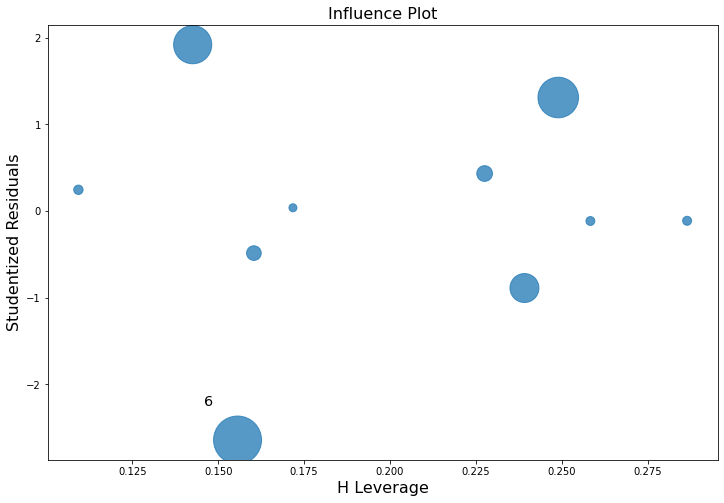

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, alpha  = 0.05, ax = ax, criterion="cooks")

In [ ]:
configure_plotly_browser_state()
studentized_residuals = influence.resid_studentized_external

cook = influence.cooks_distance[0]
# Scaling bizarre dans la fonction influence_plot de statsmodels
# qu'on essaie de reproduire ici
size=48
old_range = np.ptp(cook)
new_range = size**2 - 8**2
psize = (cook - cook.min()) * new_range/old_range + 8**2

trace = Scatter(
    x=leverage,
    y=studentized_residuals,
    mode='markers+text',
    marker_size=0.03*psize,
    name="Data points",
    text=[f"Point {i+1} , Cook D : {cook[i]:.3f}" for i in range(10)],
    textposition="top center"
)
trace2 = Scatter(
    x=[sum(leverage)/len(leverage),sum(leverage)/len(leverage)+1e-10],
    y=[-3.5,3.],
    mode='lines',
    line=dict(width=4,dash='dash'),
    name="High leverage limit",
)
fig = dict(data=[trace,trace2], layout={})
fig['layout']['xaxis'] = dict(title='H leverage')
fig['layout']['yaxis'] = dict(title='Studentized Residuals')
fig['layout']['title'] = dict(text='Influence plot')

iplot(fig)

Dans le plot précédent, on a essayé de reproduire le plot d'influence de `statsmodels` qui trace les valeurs des leviers versus le résidus studentisé. Cette dernière quantité indique l'erreur faite par le modèle linéaire pour un point donné. Ainsi, on peut voir à la fois les points qui ont un effet de levier important et l'erreur faite par le modèle. Les points les plus problématiques étant ceux qui ont à la fois un fort levier et un résidu important. Dans ce cas, seul le point 8 est éventuellement problématique. Enfin, ce graphe a une troisième dimension indiquée par la taille des points. Cette dernière dépend de la distance de Cook (voir [ici](http://eric.univ-lyon2.fr/~ricco/cours/slides/Reg_Multiple_Points_Atypiques.pdf)). Cette distance mesure l'effet de la suppression d'une donnée sur le modèle linéaire et se calcule aussi à partir de la hat matrix. En résumé, plus cette distance est grande, plus la suppression du point aura un effet important sur les autres valeurs. Il n'y a pas de consensus sur les valeurs seuils, mais des valeurs de la distance de Cook proche de $1$ indiquent des points à considérer avec attention.

## Exemple de calcul de Total Least Squares

On termine cette partie du notebook conscrée aux modèles de régression en décrivant deux approches pour réaliser une régression par Moindres Carrés Totaux telle que présentée dans la formation. Les parties de codes suivantes sont librement inspirées de [cet article](https://towardsdatascience.com/total-least-squares-in-comparison-with-ols-and-odr-f050ffc1a86a)

Supposant maintenant que nous introduisons une erreur de mesure sur les entrées.

$$ Y = 2 \times (X+\varepsilon_1) + 1 + \varepsilon_2$$

avec $\varepsilon_1$ l'erreur de mesure sur les entrées. On diminue l' erreur sur la sortie pour se mettre dans un cas où la source d'erreur est principalement sur les entrées.


In [ ]:
import numpy as np
X_init = np.random.random(50)
eps1 = 0.1*np.random.randn(50)
eps2 = 0.01*np.random.randn(50)
Y_true = 2*X_init+1
X_real = X_init+eps1
Y_real = 2*X_real+1+eps2


In [ ]:
configure_plotly_browser_state()
trace = Scatter(
    x=X_init,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Observed Data",
)
trace2 = Scatter(
    x=X_real,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Real Data (non observable)",
)
x_gr = np.linspace(np.minimum(X_init.min(), X_real.min()),np.maximum(X_init.max(), X_real.max()))
y_gr = 2*x_gr+1
trace3 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Real Model"
)
fig = dict(data=[trace,trace2,trace3], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

On utilise la fonction de l'article cité plus haut

In [ ]:
import numpy.linalg as la
def tls(X,y):
    
    if X.ndim is 1: 
        n = 1 # the number of variable of X
        X = X.reshape(len(X),1)
    else:
        n = np.array(X).shape[1] 
    
    Z = np.vstack((X.T,y)).T
    U, s, Vt = la.svd(Z, full_matrices=True)
    
    V = Vt.T
    Vxy = V[:n,n:]
    Vyy = V[n:,n:]
    a_tls = - Vxy  / Vyy # total least squares soln
    
    Xtyt = - Z.dot(V[:,n:]).dot(V[:,n:].T)
    Xt = Xtyt[:,:n] # X error
    y_tls = (X+Xt).dot(a_tls)
    fro_norm = la.norm(Xtyt, 'fro')
    
    return y_tls, X+Xt, a_tls, fro_norm

In [ ]:
M_init = np.ones([len(X_init),2])
M_init[:,1] = X_init
y_tls,X_tls,coeff_tls,fro_norm = tls(M_init, Y_real)

Les coefficients de la régression par moindres carrés totaux sont dans la variables `coeff_tls`

In [ ]:
a_tls, b_tls = coeff_tls[1], coeff_tls[0]
print(f"a: {a_tls}, b: {b_tls}")

a: [1.97408623], b: [1.01398295]


On peut maintenance comparer la régression avec la régression classique

In [ ]:
b_ols, a_ols = np.linalg.lstsq(M_init,Y_real)[0]
print(f"a: {a_ols}, b: {b_ols}")

a: 1.8251451669292074, b: 1.079603568139644


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [ ]:
configure_plotly_browser_state()
trace = Scatter(
    x=X_init,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Observed Data",
)
trace2 = Scatter(
    x=X_real,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Real Data (non observable)",
)
x_gr = np.linspace(np.minimum(X_init.min(), X_real.min()),np.maximum(X_init.max(), X_real.max()))
y_gr = 2*x_gr+1
trace3 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Real Model"
)
y_tls = a_tls*x_gr+b_tls
trace4 = Scatter(
    x=x_gr,
    y=y_tls,
    mode='lines',
    line=dict(width=4),
    name="TLS regression"
)
y_ols = a_ols*x_gr+b_ols
trace5 = Scatter(
    x=x_gr,
    y=y_ols,
    mode='lines',
    line=dict(width=4),
    name="OLS regression"
)
fig = dict(data=[trace,trace2,trace3,trace4,trace5], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

On observe que la régression par Moindres Carrés Totaux est plus proche du vrai modèle (non observable). Enfin, mentionnons qu'il existe dans `scipy` des routines plus générales (basées sur [ODRPACK](https://docs.scipy.org/doc/external/odrpack_guide.pdf), librairie en Fortran 77, `ODR` signifiant _Orthogonal Distance Regression_) qui implémentent les Moindres Carrés Totaux. Cette implémentation permet de traiter des modèles non linéaires ou avec régularisation car elles reposent sur la résolution itérative du problème d'optimisation.

In [ ]:
from scipy.odr import Model, Data, RealData, ODR


# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
   m, c = p
   return m*x + c

# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(X_init, Y_real)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[2., 2.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [2.07436943 0.95713159]
Beta Std Error: [0.12127431 0.06733258]
Beta Covariance: [[ 1.58842874 -0.7805741 ]
 [-0.7805741   0.48964422]]
Residual Variance: 0.009259123853222296
Inverse Condition #: 0.19735272736036294
Reason(s) for Halting:
  Sum of squares convergence


Dans la mesure où les méthodes de résolution sont largement différentes, il n'est pas surprenant de retrouver des résultats différents. On finit par tracer toutes les différentes régressions.

In [ ]:
a_odr, b_odr = out.beta

In [ ]:
configure_plotly_browser_state()
trace = Scatter(
    x=X_init,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Observed Data",
)
trace2 = Scatter(
    x=X_real,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Real Data (non observable)",
)
x_gr = np.linspace(np.minimum(X_init.min(), X_real.min()),np.maximum(X_init.max(), X_real.max()))
y_gr = 2*x_gr+1
trace3 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Real Model"
)
y_tls = a_tls*x_gr+b_tls
trace4 = Scatter(
    x=x_gr,
    y=y_tls,
    mode='lines',
    line=dict(width=4),
    name="TLS regression"
)
y_ols = a_ols*x_gr+b_ols
trace5 = Scatter(
    x=x_gr,
    y=y_ols,
    mode='lines',
    line=dict(width=4),
    name="OLS regression"
)
y_odr = a_odr*x_gr+b_odr
trace6 = Scatter(
    x=x_gr,
    y=y_odr,
    mode='lines',
    line=dict(width=4),
    name="ODR regression"
)

fig = dict(data=[trace,trace2,trace3,trace4,trace5,trace6], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

# Introduction aux classifieurs linéaires

On présente brièvement l'entraînement d'un classifieur linéaire de régression logistique avec le module `sklearn`.

## Généralités sur la régression logistique en `sklearn` 

Le module `linear_model` de `sklearn` comprend la classe `LogisticRegression`  qui implémente l'entraînement d'un classifieur linéaire par régression logistique. Comme on l'a vu en formation, l'entraînement consiste à minimiser la quantité suivante 
$$ \sum_{i=1} \log(e^{-y_i(X_i^Tw+b)}+1) $$
sur les paramètres $w$ et $b$. Contrairement à la régression logistique souvent implémentée dans les logiciels statistiques qui n'introduit pas de terme de régularisation, `sklearn` a fait le choix de l'implémenter par défaut. Ainsi, le problème d'optimisation résolu par `sklearn` est 

$$ \min_{w,b} \frac{1}{2}||w||_2 + C \sum_{i=1} \log(e^{-y_i(X_i^Tw+b)}+1) $$

Par défaut, `sklearn` implémente donc la régression ridge mais on peut très bien utiliser la régularisation LASSO, sous la forme suivante :

$$ \min_{w,b} ||w||_1 + C \sum_{i=1} \log(e^{-y_i(X_i^Tw+b)}+1) $$

Et enfin on peut très bien combiner les deux sous la forme de l'_Elastic Net_


$$ \min_{w,b} \rho ||w|+ \frac{1-\rho}{2}||w||_2 + C \sum_{i=1} \log(e^{-y_i(X_i^Tw+b)}+1) $$

Dans tous les cas, augmenter la valeur de $C$ diminue l'impact de la pénalisation. Pour retrouver le cas non régularisé (moins stable numériquement et risque accru d'overfitting), il faut donner une très grande valeur à ce paramètre. Cette formulation est largement inspirée par la librairie écrite en C [liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/), librairie historique notamment pour l'apprentissage de modèle linéaire avec beaucoup d'examples. 

Pour importer la classe `LogisticRegression` 

In [ ]:
from sklearn.linear_model import LogisticRegression
?LogisticRegression

## Solveurs et capacités

Lors de la formation, nous avons vu que le problème d'optimisation à résoudre pour entraîner une régression logistique n'avait
pas de solution simple écrite sous une forme analytique ou d'algèbre linéaire. Il faut donc utiliser des algorithmes d'optimisation numérique. Le plus classique dans le cas de la régression logistique étant l'IRLS (_Iterative Reweighted Least Squares_) qui n'est autre que la méthode de Newton écrite dans le cas spécifique de la régression logistique. Cette méthode revient à résoudre à chaque itération de Newton un système aux moindres carrés pondérés. De très nombreuses alternatives ont été développées pour pallier les difficultés de convergence de IRLS dans certains cas :


*   pénalisation LASSO
*   grande taille (beaucoup d'examples)

Typiquement, on trouve parmi les méthodes développées 



*   Des algorithmes classiques et tout-terrains de type quasi-Newton (`BFGS` ou limited memory `L-BFGS`) souvent efficaces en grande taille sur des objectifs dérivables qui peuvent être parallélisés efficacement.
*   les algorithmes de descentes par coordonnées (_coordinate descent_) adaptées à la régularisation LASSO et à la grande taille car se parallélise aisément, voir [ici](https://www.cs.ubc.ca/~jnutini/documents/mlrg_ParallelCD.pdf) et [là](http://josephsalmon.eu/enseignement/TELECOM/MDI720/CD_fr.pdf)
*   des formulations duales où on applique par exemple un algorithme de descente par coordonnée
*   des solveurs dédiés comme `SAG` _Stochastic Average Gradient_
*   la descente de gradient stochastique (utilisée en Deep Learning)

Voir [ce résumé](https://tminka.github.io/papers/logreg/minka-logreg.pdf) pour une comparaison numérique de différents algorithmes.

Ce qu'il faut retenir est que `sklearn` dispose de plusieurs algorithmes qui ne sont pas équivalents en terme de capacité (régularisation LASSO) ou de performance. Enfin, certains algorithmes ont été naturellement étendu au cas multi-class quand d'autres non. 

En définitive, on peut utiliser les solveurs suivants :



*   `newton-cg` gradient conjugué et Newton
*   `lbgfs` Limite Memory BFGS
*   `liblinear` descente par coordonnées implémentée dans `liblinear`
*   `sag` _Stochastic Average Gradient_
*   `saga` variante de SAG adaptée à la grande taille


## Comparaisons des options de solvers pour la régression logistique avec `sklearn`

Nom du solveur | Ridge | LASSO | Elastic  | Grande taille | Multi-classes | Sans régularisation
--- | --- | --- | --- | --- | --- | ---
`liblinear`  | Oui | Oui | Non | Oui | Non | Non
`lbfgs`  | Oui | Non | Non | Non | Oui | Oui
`newton-cg`  | Oui | Oui | Non | Non | Oui | Non
`sag`  | Oui | Non | Non | Non | Oui | Non
`saga`  | Oui | Oui | Oui | Oui | Oui | Oui

## Stratégie de réglage des hyperparamètres

En définitive , il y a essentiellement $2$ (éventuellement $3$ avec l'_Elastic Net_) hyperparamètres à régler lors de l'apprentissage :


*   Degré polynomial de la régression
*   Paramètre de régularisation $C$

En pratique, il est rare de devoir augmenter le degré polynomial mais en toute rigueur rien ne l'empêche. Toutefois on limite ce degré car on a souvent affaire à des problèmes de grande dimension d'entrées ($n_{features}$). Dans de tels cas, augmenter le degré augmente le nombre de paramètres considérablement et complique la convergence des algorithmes d'optimisation. A l'inverse, un changement de $C$ n'a pas un impact significatif sur le temps de convergence. Au final, il faut tout de même régler le paramètre $C$.

## Premier exemple : prédiction de la défaillance pour la navette Challenger

![Texte alternatif…](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Challenger_Photo_Montage.jpg/280px-Challenger_Photo_Montage.jpg)

En 1986, la navette Challenger explose 73 secondes après son envol. Lors de l'enquête qui a suivi cette tragédie , il fut découvert que l'explosion avait pour origine une fuite de gaz chauds causée par la défaillance d'un joint torique d'un des deux boosters. Cette défaillance a finalement été expliquée par les températures froides la nuit précédant le lancement ($31 °F$). L'objet de cette exemple est, à partir des données d'estimer la probabilité de défaillance du joint à partir des données constructeurs.

Les données sont les suivantes avec $X$ qui désigne la température (en degré Farenheit) et $y$ qui désigne la défaillance ou non à cette température : $1$ désignant la défaillance

In [ ]:
X = [[53.0],[56.0],[57.0],[63.0],[66.0],[67.0],[67.0],[67.0],[68.0],[69.0],[70.0],[70.0],[70.0],[70.0],[72.0],[73.0],[75.0],[75.0],[76.0],[76.0],[78.0],[79.0],[80.0],[81.0]]
y = [[1.0],[1.0],[1.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[1.0],[0.0],[1.0],[0.0],[0.0],[0.0],[1.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]]
X = np.array(X).flatten()
y = np.array(y).flatten()

On commence par visualiser les données

In [ ]:
configure_plotly_browser_state()
x_gr = np.linspace(0,1,3)
y_gr = a*x_gr+b
trace = Scatter(
    x=X[y == 1.0],
    y=y[y == 1.0],
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{x} °F" for x in X[y == 1.0]],
    textposition="top center",
    name="Failure",
)
trace2 = Scatter(
    x=X[y == 0.0],
    y=y[y == 0.0],
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{x} °F" for x in X[y == 0.0]],
    textposition="top center",
    name="Not Failure",
)
fig = dict(data=[trace,trace2], layout={})
fig['layout']['xaxis'] = dict(title='Temperature (in F)')
fig['layout']['yaxis'] = dict(title='Failure')

iplot(fig)

On ne va pas construire de base de test ou de validation dans ce cas précis, car le but n'est pas de construire un modèle prédictif mais de trouver un modèle qui explique les données. Toutefois pour éviter le surapprentissage on va utiliser le leave-one out piour déterminer le meilleur paramètre de régularisation $C$.

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
loo = LeaveOneOut()
loo.get_n_splits(X)

24

Pour chaque valeur de $C$, on va donc construire $24$ modèles et on calculera la valeur moyenne de la précision sur ces $24$ modèles. Typiquement, pour $C=10$, cela donne :

In [ ]:
C = 10
res = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LogisticRegression(C=C)
    clf.fit(X_train.reshape(-1,1), y_train)
    res.append(clf.score(X_test.reshape(-1, 1), y_test))

On va créer une fonction qui à $C$ renvoie la valeur de leave-one-out

In [ ]:
def leave(C=10,loo=loo):
  res = []
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LogisticRegression(C=C)
    clf.fit(X_train.reshape(-1,1), y_train)
    res.append(clf.score(X_test.reshape(-1, 1), y_test))
  return np.mean(np.array(res))

On trace ensuite les valuers de leave-one-out pour des $C$ qui varient entre $10^{-5}$ et $10^{3}$. Dans la mesure où la bonne gamme de valeurs pour $C$ n'est jamais connu à l'avance, il est souvent conseillé d'échantillonner en log afin de couvrir un grand domaine de valeur possible.

In [ ]:
C_int = np.logspace(-5.,3.,100)
res_loo = []
for C in C_int:
  res_loo.append(leave(C,loo))
print(res_loo)

[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7916666666666666, 0.7916666666666666, 0.8333333333333334, 0.8333333333333334, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.83333333333

In [ ]:
configure_plotly_browser_state()
trace = Scatter(
    x=C_int,
    y=res_loo,
    mode='markers',
    marker=dict(size=13),
    text=[f"C : {C} " for C in C_int],
    textposition="top center",
    name="LOO",
)
fig = dict(data=[trace], layout={})
fig['layout']['xaxis'] = dict(title='C ridge regularization parameter')
fig['layout']['yaxis'] = dict(title='Leave One Out Accuracy')
fig['layout']['xaxis'] = dict(type="log")

iplot(fig)

Dans le graphe précédent, on voit que les bonnes valeurs de $C$ se trouvent entre 0.01 et 0.1. On prend arbitrairement $C=0.02$ dans la suite et on entraîne le modèle final sur tous les points.

In [ ]:
C = 0.02
clf = LogisticRegression(C=C)
clf.fit(X.reshape(-1,1), y)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

On peut maintenance évaluer la prédiction du modèle à $31 °F$

In [ ]:
clf.predict([[31.]])

array([1.])

On peut aussi évaluer la probabilité de défaillance pour la température de $31 °F$.

In [ ]:
clf.predict_proba([[31.]])[0][1]

0.9849326835316076

Le modèle prédit donc une défaillance à $31 °F$ avec une probabilité de $98.5\%$. Pour visualiser cette probabilité en fonction de la température, traçons finalement la courbe

In [ ]:
configure_plotly_browser_state()
x_gr = np.linspace(28,85,100)
proba_pred = clf.predict_proba(x_gr.reshape(-1, 1))
y_gr = [a[1] for a in proba_pred]
trace = Scatter(
    x=X[y == 1.0],
    y=y[y == 1.0],
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{x} °F" for x in X[y == 1.0]],
    textposition="top center",
    name="Failure",
)
trace2 = Scatter(
    x=X[y == 0.0],
    y=y[y == 0.0],
    mode='markers+text',
    marker=dict(size=13),
    text=[f"{x} °F" for x in X[y == 0.0]],
    textposition="top center",
    name="Not Failure",
)
trace3 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),    
    name="Probability of failure",
)
trace4 = Scatter(
    x=[31.0 ,31.0+1e-5],
    y=[0., clf.predict_proba([[31.]])[0][1]],
    mode='lines+text',
    text=[f"{clf.predict_proba([[31.]])[0][1]:.3f} prob. at 31°F" ],
    textposition="bottom center",
    line=dict(width=2,dash='dash'),    
    name="Challenger Temp.",
)
fig = dict(data=[trace,trace2,trace3,trace4], layout={})
fig['layout']['xaxis'] = dict(title='Temperature (in F)')
fig['layout']['yaxis'] = dict(title='Failure')

iplot(fig)

Exercice 4 :


*   Changer le solveur pour voir si cela a une influence sur les résultats
*   Déterminer les meilleurs valeurs pour $C$ avec une régularisation LASSO




## Demonstration en multi-classe sur le dataset wine quality

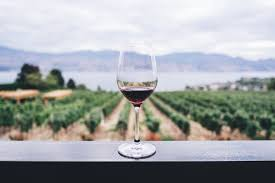 

On va appliquer la classe `LogisticRegression` sur un dataset classique en Machine Learning : _Wine Quality dataset_ qui décrit la composition chimique de certains vins et prédit en sortie sa qualité. 

Les lignes suivantes décrivent l'import des données et la création d'un `pandas` dataframe.

In [ ]:
import pandas as pd
from sklearn.datasets import load_wine
rd = load_wine()
X, y = load_wine(return_X_y=True)
df = pd.DataFrame(X, columns=rd.feature_names)
df['target'] = y
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
df.target.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

On dispose donc de $178$ examples; il s'agit d'un problème multiclasse (on a $3$ classes). On commence par séparer les données en bases d'apprentissage et de test. On va directement sélectionner les meilleurs modèles sur la base d'apprentissage par validation croisée.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:,-1], random_state=34)

On commence par les réglages par défaut

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
lr =  LogisticRegressionCV(cv=5, Cs=[0.01,0.1,1.,10,100])
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

LogisticRegressionCV(Cs=[0.01, 0.1, 1.0, 10, 100], class_weight=None, cv=5,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
lr.scores_

{0: array([[0.96296296, 1.        , 1.        , 0.96296296, 0.96296296],
        [0.85185185, 0.88888889, 0.88888889, 0.88888889, 0.88888889],
        [0.96296296, 1.        , 0.96296296, 0.92592593, 0.92592593],
        [0.88461538, 0.92307692, 0.96153846, 0.96153846, 0.92307692],
        [0.92307692, 0.96153846, 0.96153846, 0.96153846, 0.96153846]]),
 1: array([[0.96296296, 1.        , 1.        , 0.96296296, 0.96296296],
        [0.85185185, 0.88888889, 0.88888889, 0.88888889, 0.88888889],
        [0.96296296, 1.        , 0.96296296, 0.92592593, 0.92592593],
        [0.88461538, 0.92307692, 0.96153846, 0.96153846, 0.92307692],
        [0.92307692, 0.96153846, 0.96153846, 0.96153846, 0.96153846]]),
 2: array([[0.96296296, 1.        , 1.        , 0.96296296, 0.96296296],
        [0.85185185, 0.88888889, 0.88888889, 0.88888889, 0.88888889],
        [0.96296296, 1.        , 0.96296296, 0.92592593, 0.92592593],
        [0.88461538, 0.92307692, 0.96153846, 0.96153846, 0.92307692],
       

# Modèles linéaires de grande taille

Finalement, précisons qu'il existe des frameworks et des approches dédiés à l'apprentissage de modèles linéaires de très grande taille. Par grande taille, cela signifie un très grand nombre d'examples (plusieurs milliards). ELors de la formation, on a par exemple mentionné le modèle de régression logistique pour prédire le _Click Through Rate_ chez CRITEO. 

Dans ces cas, il est nécessaire d'utiliser des frameworks adaptés et des approches particulières car les examples ne tiennent plus dans la mémoire vive d'un seul ordinateur et les algorithmes classiques (Newton...) montrent leur limite. 

Certains frameworks orientés Big Data comme [Spark](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression) et sa librairie MLlib disposent d'implémentations spécifiques d'algorithmes permettant l'apprentissage distribué sur plusieurs machines.

Enfin, les librairies de Deep Learning permettent aussi l'entraînement de modèles linéaires sur d'énormes data set, en s'appuyant notamment sur la Descente de Gradient Stochastique